Hi

I have made this notebook because of an issue I came accross when working on a dataviz project. I needed to realize a choropleth map with France's overseas territories as well as metropolitan territories. After an attempts with subplots, I realized my easiest option was to directly modify overseas territories coordinates. The code below explains how I did it. 

Information about France's territories in this notebook:
 - Regions and departements are plotted
 - There are 13 Metropolitan regions et 96 metropolitan departements
 - There are 5 overseas regions and departements. Overseas regions are regions-departments. 



# Install & imports necessary

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Imports departements geojson

In [4]:
# file with geometric shape of France's departments (without overseas)
dpt = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson"
df_dpt = gpd.read_file(dpt)

print(type(df_dpt))
print(df_dpt.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
(96, 3)


In [5]:
df_dpt.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


# Import regions geojson

In [6]:
# file with geometric shape of France's regions (with overseas)
reg_avec_om = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions-avec-outre-mer.geojson"
df_reg_avec_om = gpd.read_file(reg_avec_om)

print(type(df_reg_avec_om))
print(df_reg_avec_om.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
(18, 3)


In [7]:
df_reg_avec_om.head(5)

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.59602 49.08171, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.87984 47.51671, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.62655 46.75228, ..."
3,28,Normandie,"MULTIPOLYGON (((-1.11962 49.35557, -1.11554 49..."
4,32,Hauts-de-France,"POLYGON ((4.14090 49.97876, 4.14407 49.97625, ..."


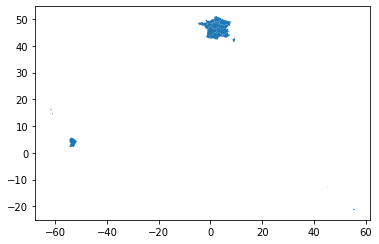

In [8]:
# what it would like without changing the coordinates
# plot 
df_reg_avec_om.plot()
plt.show()

In [9]:
## separate regions' geodataframe with metropolitan regions on one side and overseas regions on the other

# sort region code in ascending order
df_reg_avec_om = df_reg_avec_om.sort_values(by="code") 

# for overseas regions (5 regions-departements) keep first 5 lines 
df_rom = df_reg_avec_om[:5] 
df_rom = df_rom.reset_index(drop=True)

# for metropolitan France (13 regions)
df_reg = df_reg_avec_om[5:]  
df_reg = df_reg.reset_index(drop=True)

print(type(df_rom), df_rom.shape)
print(type(df_reg), df_reg.shape)

<class 'geopandas.geodataframe.GeoDataFrame'> (5, 3)
<class 'geopandas.geodataframe.GeoDataFrame'> (13, 3)


* **choose anchor point to bring overseas region closer to metropolitan France** 

In [10]:
# choose 5 anchor points
anchor_pt = pd.DataFrame([[51, -7.223655], [49, -7.223655], [47, -7.223655], [45, -7.223655], [43, -7.223655]], columns=["lat", "lon"])
anchor_pt

,lat,lon
0,51,-7.223655
1,49,-7.223655
2,47,-7.223655
3,45,-7.223655
4,43,-7.223655


In [12]:
# find the centroïd of each region's multipolygon 
df_rom["geometry"] = df_rom['geometry'].to_crs("EPSG:4326")
df_rom["center"] = df_rom['geometry'].centroid  
df_rom

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


,code,nom,geometry,center
0,01,Guadeloupe,"MULTIPOLYGON (((-61.79038 16.16682, -61.79164 ...",POINT (-61.53943 16.19773)
1,02,Martinique,"MULTIPOLYGON (((-60.86733 14.38867, -60.86802 ...",POINT (-61.01841 14.65318)
2,03,Guyane,"MULTIPOLYGON (((-53.87049 5.74494, -53.86464 5...",POINT (-53.23535 3.92358)
3,04,La Réunion,"MULTIPOLYGON (((55.56891 -21.37670, 55.56843 -...",POINT (55.53254 -21.13326)
4,06,Mayotte,"MULTIPOLYGON (((45.04101 -12.64686, 45.04139 -...",POINT (45.14744 -12.82062)


In [13]:
# calculate the distance in latitude and longitude between the centroïd and its corresponding anchor point 

dist_list =[]

for i, row in df_rom.iterrows():
    x_dist = anchor_pt.loc[i, "lon"] - (row["center"].x)  # différence entre longitude
    y_dist = anchor_pt.loc[i, "lat"] - (row["center"].y)  # différence entre latitude
    dist_list.append((x_dist, y_dist))  # ajouter à la liste

dist_list

[(54.31577971685846, 34.80227083315512),
 (53.79475812830232, 34.346815331503464),
 (46.011693861377545, 43.076417030966844),
 (-62.756192214959334, 66.13325609700435),
 (-52.37109553170058, 55.82061630358814)]

* **retrieve a geodataframe per overseas region to use the method geoseries.translate()** : GeoSeries.translate() can only be used on the whole series of a datframe. In our case, the distance apply to coordinates depend on each region. Therefore, we need to separate each region into distinct geodataframe. 

In [14]:
# keep each line in different geodataframe
guadeloupe = gpd.GeoDataFrame(df_rom.iloc[0,]).T
martinique = gpd.GeoDataFrame(df_rom.iloc[1,]).T
guyane = gpd.GeoDataFrame(df_rom.iloc[2,]).T
reunion = gpd.GeoDataFrame(df_rom.iloc[3,]).T
mayotte = gpd.GeoDataFrame(df_rom.iloc[4,]).T

In [15]:
# resize Guyane which is bigger than other overseas departments

guyane["geometry"] = guyane["geometry"].scale(0.15,0.15)
guyane

,code,nom,geometry,center
2,03,Guyane,"MULTIPOLYGON (((-53.22434 4.20202, -53.22346 4...",POINT (-53.235348861377545 3.923582969033157)


In [16]:
# shift coordinates of each overseas regions by the distance find earlier
guadeloupe["geometry"] = guadeloupe["geometry"].translate(dist_list[0][0], dist_list[0][1])
martinique["geometry"] = martinique["geometry"].translate(dist_list[1][0], dist_list[1][1])
guyane["geometry"] = guyane["geometry"].translate(dist_list[2][0], dist_list[2][1])
reunion["geometry"] = reunion["geometry"].translate(dist_list[3][0], dist_list[3][1])
mayotte["geometry"] = mayotte["geometry"].translate(dist_list[4][0], dist_list[4][1])

In [17]:
# concatenate new coordinates in a new geodataframe
rom = pd.concat([guadeloupe, martinique, guyane, reunion, mayotte], axis=0)

# resize again the regions 
rom["geometry"] = rom["geometry"].scale(3,3)

In [18]:
# delete "center" columns
del rom["center"]

In [19]:
rom

,code,nom,geometry
0,01,Guadeloupe,"MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50..."
1,02,Martinique,"MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48..."
2,03,Guyane,"MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47..."
3,04,La Réunion,"MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44..."
4,06,Mayotte,"MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43..."


In [20]:
# compare with precedent values
df_rom

,code,nom,geometry,center
0,01,Guadeloupe,"MULTIPOLYGON (((-61.79038 16.16682, -61.79164 ...",POINT (-61.53943 16.19773)
1,02,Martinique,"MULTIPOLYGON (((-60.86733 14.38867, -60.86802 ...",POINT (-61.01841 14.65318)
2,03,Guyane,"MULTIPOLYGON (((-53.87049 5.74494, -53.86464 5...",POINT (-53.23535 3.92358)
3,04,La Réunion,"MULTIPOLYGON (((55.56891 -21.37670, 55.56843 -...",POINT (55.53254 -21.13326)
4,06,Mayotte,"MULTIPOLYGON (((45.04101 -12.64686, 45.04139 -...",POINT (45.14744 -12.82062)


 * **récupérer un geodataframe pour les régions avec l'outremer incluse**

In [21]:
# concate metropolitan regions with overseas regions
gdf_reg_avec_om = pd.concat([df_reg, rom], axis=0).reset_index(drop=True)

In [22]:
gdf_reg_avec_om

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.59602 49.08171, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.87984 47.51671, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.62655 46.75228, ..."
3,28,Normandie,"MULTIPOLYGON (((-1.11962 49.35557, -1.11554 49..."
4,32,Hauts-de-France,"POLYGON ((4.14090 49.97876, 4.14407 49.97625, ..."
5,44,Grand Est,"POLYGON ((4.23316 49.95775, 4.23690 49.95858, ..."
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.62284 47.40975, -2.62341 47..."
7,53,Bretagne,"MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48..."
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((1.41519 46.34722, 1.41675 46.3..."
9,76,Occitanie,"MULTIPOLYGON (((1.78613 42.57362, 1.78661 42.5..."


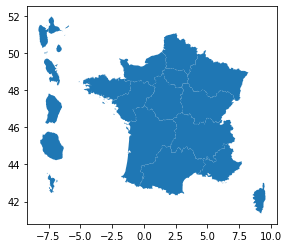

In [23]:
# plot results !
gdf_reg_avec_om.plot()
plt.show()

 * **retrieve a geodataframe for all 101 departments** : Here there is a trick because overseas regions' number  match other metropolitan departements. 

In [24]:
# change overseas region code by their department code
code_reg_dpt = {"01": "971",
                "02": "972",
                "03": "973",
                "04": "974",
                "06": "976"}

dom = rom.replace({"code": code_reg_dpt})
dom

,code,nom,geometry
0,971,Guadeloupe,"MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50..."
1,972,Martinique,"MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48..."
2,973,Guyane,"MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47..."
3,974,La Réunion,"MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44..."
4,976,Mayotte,"MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43..."


In [25]:
# concatenate metropolitan regions and overseas region 
gdf_dpt_avec_om = pd.concat([df_dpt, dom], axis=0).reset_index(drop=True)

In [26]:
gdf_dpt_avec_om

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."
...,...,...,...
96,971,Guadeloupe,"MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50..."
97,972,Martinique,"MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48..."
98,973,Guyane,"MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47..."
99,974,La Réunion,"MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44..."


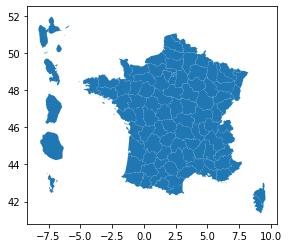

In [27]:
# plot
gdf_dpt_avec_om.plot()
plt.show()

# Export

In [28]:
# export des geojson
gdf_reg_avec_om.to_file("region_avec_outremer_rapprochée.geojson", driver="GeoJSON")
gdf_dpt_avec_om.to_file("departement_avec_outremer_rapprochée.geojson", driver="GeoJSON")